In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Sep  6 14:49:27 2024

@author: HOME
"""
#%% Cargado librerías

from openseespy.opensees import *
import matplotlib.pyplot as plt
import opsvis as opsv
import opseestools.analisis3D as an
import opseestools.utilidades as ut
import vfo.vfo as vfo
import numpy as np
import pandas as pd
import time
import opstool as opst
import opstool.vis.pyvista as opsvis
import opstool.vis.plotly as opsvis2


In [ ]:


#%% Creación del modelo

wipe()
model('basic','-ndm',3,'-ndf',6)


#%% Definicion de nodos
coordx = [0, 6, 12]
coordy = [0, 6, 12]
coordz = [0, 3, 6, 9]

masas = [90,90,90]

coords = ut.creategrid3D(coordx,coordy,coordz,1,masas)
fixZ(0.0,1,1,1,1,1,1)

#%% Definición de materiales (son según norma colombiana NSR-10, similares detallamiento especial del ACI)
fc = 28
fy = 420
noconf, conf, acero = ut.col_materials(fc,fy)

#%% Definición de elementos

Bcol = 0.35 # base de la columna
Hcol = 0.35 # altura de la columna
Bvig = 0.25 # base de la viga
Hvig = 0.40 # altura de la viga

c = 0.05  # recubrimiento de las secciones

As4 = 0.000127 # area barra #4
As5 = 0.0002 # area barra #5
As6 = 0.000286
As7 = 0.000387 # area barra #7

col30x30 = 101 # tag de la columna
vig30x40 = 201 # tag de la viga

ut.create_rect_RC_section(col30x30, Hcol, Bcol, c, conf, noconf, acero, 4, As5, 4, As5, 6, As5)
ut.create_rect_RC_section(vig30x40, Hvig, Bvig, c, conf, noconf, acero, 3, As4, 3, As4)

#%% Creando los elementos
coltags = [col30x30,col30x30, col30x30] # one section tag per floor
# cols, vigx, vigy = ut.create_elements3D(coordx, coordy, coordz, col30x30, vig30x40, vig30x40)
cols, vigx, vigy, sectag_col = ut.create_elements3D(coordx, coordy, coordz, coltags, vig30x40, vig30x40)

#%% Creando la losa
hslab = 0.10 # altura de la losa
Eslab = 1000*4400*(28)**0.5 # módulo de elasticidad de la losa
pois = 0.3 # relación de Poisson de la losa


ut.create_slabs(coordx, coordy, coordz, hslab, Eslab, pois)
# vfo.plot_model(show_nodetags='yes', show_eletags='yes', show_nodes='yes')

#%% Cargando las vigas
floorx = -20  
floory = -20
roofx = -10 
roofy = -10
ut.load_beams3D(-20, -10, -20, -10, vigx, vigy, coordx, coordy)

#%% calculando modos

eig = eigen('-fullGenLapack',(len(coordz)-1)*2)
modalProperties('-print', '-unorm')

opst.post.save_model_data(odb_tag=1)
opsvis2.set_plot_props(point_size=0, line_width=3)
fig = opsvis2.plot_model(odb_tag=1, show_outline=True)
fig.show()

HystereticSM: multi-point envelope + DCR recorders  - Code by Silvia Mazzoni, 2023 (silviamazzoni@yahoo.com) 

WARNING - the 'fullGenLapack' eigen solver is VERY SLOW. Consider using the default eigen solver.Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-1.nc!

OPSTOOL ::  Loading model data from _OPSTOOL_ODB/ModelData-1.nc ...

Análisis de gravedad completado
DB Created


after: 10 iterations  current Norm: 1.07512 (max: 0.0001, Norm deltaX: 4.91602e-05)
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 825.121
OpenSees > analyze failed, returned: -3 error flag


configuración por defecto no converge en desplazamiento:  0.21100000000000016


OPSTOOL ::  All responses data with odb_tag = 1001 saved in _OPSTOOL_ODB/RespStepData-1001.nc!

tiempo de ejecucion:  6.787031412124634 segundos


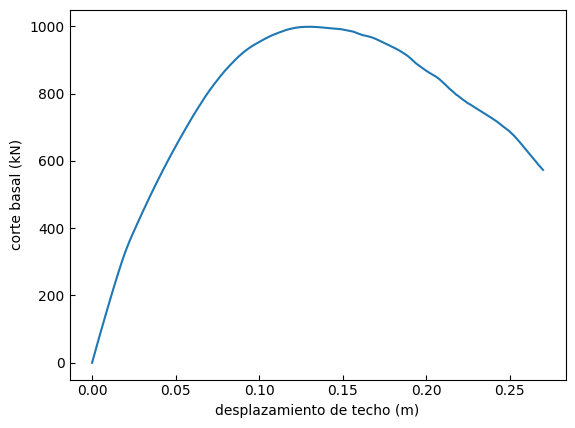

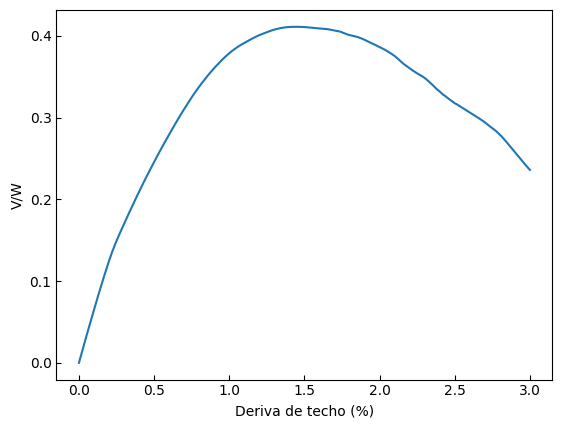

In [3]:


#%% Analizando el modelo

an.gravedad()
plt.show()
loadConst('-time',0.0)

ut.pushover_loads3D(coordz)
stime = time.time()
dtecho,Vbasal = an.pushover2DB(coordz[-1]*0.03, 0.001, len(coordz)-1, 1,norm=[coordz[-1],np.sum(masas)*9,81])
etime = time.time()
ttotal = etime - stime
print('tiempo de ejecucion: ',ttotal,'segundos')
plt.show()


In [4]:
#%% Usando la librería de opstool y sus potentes capacidades de visualización
opsvis.set_plot_props(font_size=8,
                      title_font_size=10,
                      line_width=5,
                      point_size=3)
opsvis.plot_nodal_responses_animation(
    odb_tag=1001, # by default IDA2DB uses an odb_tag of 1000.
    resp_type="disp",
    resp_dof=["UX", "UY"],
    framerate=30,
    savefig="Pushover.mp4",
    scale=3.0,
).close()

OPSTOOL ::  Loading response data from _OPSTOOL_ODB/RespStepData-1001.nc ...

Animation saved to Pushover.mp4!


In [5]:
from IPython.display import Video

Video("Pushover.mp4", embed=True, width=800, height=600)